# Axegine Optimal B/A Pricing Model

AJ Lindeman

June 2018

## Problem (re) statement and analysis

We are making markets in a single risky asset having a lognormal price process
$$
dP_t = P_t\left( \mu\,dt + \sigma\,dW_t\right).
$$

Buy and sell orders are modeled as a Poisson counting process with densities $\lambda_0^b$ and $\lambda_0^s$. Our quotes take the form
$$
P_te^s_t
$$
and the probability the quote is accepted is modeled as
$$
\lambda_1^\cdot(s_t) = e^{-\beta s^\cdot_t}.
$$
Note $\beta$ is a parameter reflecting the fact that we cannot guarantee winning the trade by setting the spread to zero:
$$
P(\text{agent}\,\text{buys}\,\vert\, s\in[0,\delta)) = \int_0^\delta e^{-\beta s}\,ds=1-\frac 1\beta e^{-\beta\delta} \approx 1 - \frac 1\beta +\delta.
$$
Obviously we must have $\beta\geq 1$, and really only $\beta > 1$ is realistic, as other dealers may be better buyers and sellers (perhaps using a different utility function than us).

_**Claim**: Accepted trades arrive at rate $\lambda^\cdot = \lambda_0^\cdot \times \lambda_1^\cdot.$_ (TODO)

Trade quantities are denoted by $Q$. In this setup the change in inventory is goverened by
$$
dI_t = \left(Q^s\lambda^s - Q^b\lambda^b\right)\,dt
$$
In words, the difference between expected agent sells (our buys) and expected agent buys (our sells) over a small time period.

The change in our cash account is similar, except that we have to reflect the transaction prices:
$$
dC_t = P_t\left(Q^b\lambda^b e^{s^A} - Q^s\lambda^s e^{-s^B} \right)\,dt
$$
As a mental check, if we take $Q=1$ and $s=s^A=s^B$ and $\lambda = \lambda^b = \lambda^a$ we have
$$
dC_t = Q\lambda P_t\left(e^s - e^{-s}\right)\,dt\approx 2 Q\lambda P_t s\,dt
$$
which is twice the ("proportional") spread times the expected quantity traded. (I.e. the spread convention here is a percentage of value, not the more usual absolute amount.)

Our wealth process is simply the sum of the cash account and value of our position (taken at mid):
$$
\Pi_t = C_t + I_t P_t,
$$
and we are asked to choose a policy $\left\{s^A_t, s^B_t\right\}$ that maximizes exponential utility at some terminal time $T$:
$$
   \max {\bf E}\left[-e^{-\Pi(T)}\right]
$$

### Observations

* No time value of money (risk-free rate is zero).
* Can borrow indefinitely, implying no upper limit on long position
* Can short indefinitely
* No penalty for holding inventory; no link between spreads and inventory
* No explicity hedging of position, although $P_t$ could reprsent the price dynamics of a hedged portfolio
* Might re-parameterize to the arrival rate of unit orders - i.e. collapse $Q$ and $\lambda$.

### Overall solution strategy

* Simulate to check understanding and validate expected sensitivites, such as 
  * Don't really see any time-dependence here
  * Similarly the policy won't depend on position, 
  * So perhaps it doesn't depend on wealth, and it's a constant 
  * Bid and ask spreads won't be symmetric - the asymmetry should be controlled by $\mu$ and the relative arrival rates of buy and sell orders (and relative buy and sell sizes).
  * Bid and ask spreads increase with $\sigma$
* Write down the SDE for the wealth process
* Find the infinitessimal generator and pose the optimization as an HJB equation
* Assume a classical solution and "differentiate" to find the optimal policy
* Analyze the PDE more to see what we can say about expected terinal wealth

## Simulation

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [315]:
T = 2 # days
dt = 0.125 # 8 trading hours per day
Qs = 1.0 # unit customer sell size
Qb = 1.0 # unit customer buy size
mu = 0.02/250.0  # 2% per annum
sig = 0.01/np.sqrt(T) # 1% asset vol (eg high-quality bond)
lam0s = 0.6033*8.0 # 33% chance per dt via P(N(1/8)=1) = lam/8 exp(-lam/8) = 0.33
lam0b = lam0s # let's make buys and sells symmetric
beta = 4.0 # so we are only X% likely to win a trade with a zero spread
gam = 0.1

In [316]:
def run_sim(sA, sB):
    ns = 1000
    P0 = 100.0
    Pt = np.zeros((T+1, ns))
    Ct = np.zeros((T+1, ns))
    It = np.zeros((T+1, ns))
    Vt = np.zeros((T+1, ns))
    Pt[0,:] = P0
    for t in range(T):
        # price process
        Wt = np.random.normal(scale=np.sqrt(dt), size=ns)
        Pt[t+1,:] = Pt[t,:] * np.exp((mu-0.5*sig**2)*dt) * np.exp(sig*Wt)
        # order arrivals
        b_t = Qb*np.random.poisson(lam0b/12, ns) # something is not right with lam0s...
        s_t = Qs*np.random.poisson(lam0s/12, ns)
        # trades need to be won - both on the beta condition and spread
        # we "implement the loss" either B1 ~ Bern(1-1/beta) is zero or B2 ~ Bern(exp(-s)) is zero
        # if beta = 1, then the first condition is Unif(0,1) < 0 which is false -> second condition gets a chance
        # if sA = 0, then the second condition is Unif(0,1) < 0 which is also false -> so we always win
        b_t[ (np.random.uniform(size=ns) < 1.0-1.0/beta) 
            |(np.random.uniform(size=ns) < 1.0 - np.exp(-sA))] = 0.0 # implemented as lost
        s_t[ (np.random.uniform(size=ns) < 1.0-1.0/beta)
            |(np.random.uniform(size=ns) < 1.0 - np.exp(-sB))] = 0.0
        print ('**', np.sum(b_t)/ns, np.sum(s_t)/ns)
        #print(b_t)
        It[t+1,:] = It[t,:] + (s_t - b_t) # customer sells - customer buys
        Ct[t+1,:] = Ct[t,:] + Pt[t,:]*(b_t*np.exp(sA) - s_t*np.exp(-sB)) # cust buys at P*e^sA...
        Vt[t+1,:] = Ct[t+1,:] + It[t+1,:]*Pt[t+1,:] # note we quoted at P(t), marked at P(t+1)
    return Vt, Ct, It

** 0.09 0.096
** 0.089 0.089
0.183619435616 0.526326123511 -0.966470155172


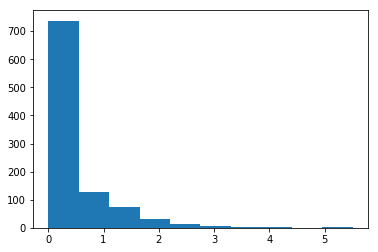

In [319]:
np.random.seed(123)
sA = 0.01
sB = 0.01
Vt, Ct, It = run_sim(sA, sB)
UT = -np.exp(-gam*Vt[T,])
print(np.mean(Vt), np.std(Vt), np.mean(UT))
plt.hist(Vt[T,])
plt.show()

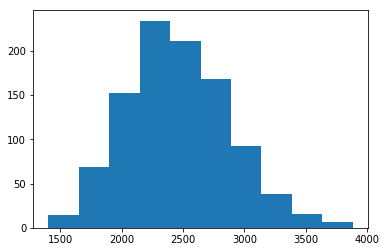

In [137]:
np.array(range(ns))[np.sum(Ct,axis=0)<0]

array([  3,   5,   7,  11,  12,  15,  27,  28,  32,  33,  35,  37,  40,
        41,  44,  45,  50,  52,  57,  58,  64,  66,  76,  78,  82,  85,
        88,  90,  98, 101, 104, 106, 108, 110, 113, 114, 118, 129, 137,
       138, 143, 149, 151, 153, 155, 157, 169, 178, 179, 181, 184, 188,
       192, 193, 194, 198, 206, 207, 215, 217, 218, 221, 227, 229, 230,
       235, 237, 242, 245, 246, 249, 252, 253, 257, 263, 266, 270, 277,
       279, 281, 284, 287, 294, 305, 313, 317, 322, 333, 336, 339, 350,
       354, 355, 358, 359, 360, 367, 370, 379, 380, 389, 391, 392, 404,
       405, 407, 413, 422, 424, 426, 429, 430, 434, 435, 437, 440, 444,
       446, 450, 453, 456, 458, 463, 465, 467, 469, 470, 472, 473, 475,
       476, 477, 479, 483, 486, 490, 492, 496, 504, 505, 512, 513, 515,
       518, 519, 520, 523, 526, 529, 531, 534, 535, 536, 538, 539, 542,
       555, 562, 563, 571, 575, 577, 583, 585, 599, 601, 604, 605, 606,
       607, 608, 609, 611, 613, 614, 620, 621, 634, 644, 650, 65

In [147]:
Pt[:,137]

array([ 100.        ,  100.04138878,  100.03857662,  100.05303964])

In [142]:
It[:,137]

array([ 0.,  0.,  1.,  2.])

In [143]:
Ct[:,137]

array([   0.        ,    0.        ,  -99.9413974 , -199.87998544])

In [144]:
Vt[:,137]

array([ 0.        ,  0.        ,  0.09717922,  0.22609385])

In [145]:
UT[137]

-0.97764429187794621